**Name**:
In this note book we will see how many fires are detected by GOES have clouds in them 

**Description**:  
In this notebook we will use the GOES FDC fire pixels and ACM cloud mask to see how many fires are detected by GOES have clouds in them. 

**Date created**:  
`2024-12-15`

**Author**:  
Asaf Vanunu

---

In [19]:
import os
import pandas as pd
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import GOES_VIIRS_tools

- Now we will set the path for the excel file that contains the data

In [6]:
csv_path = [os.path.join(os.getcwd(), f) for f in os.listdir(os.getcwd()) if f.endswith(".csv")][0]
print(csv_path)

c:\Users\asaf_rs\Dropbox\Fire_Detection\python_ML_project\create_ML_df\NC_VIIRS_df.csv


In [7]:
df = pd.read_csv(csv_path)
df[:5]

,GOES_file_name,GOES_date_time,MCMI,FDC,ACM,VIIRS_file,VIIRS_file_full_path
0,s202201010731.nc,2022-01-01 07:31,F:\ML_project\GOES_16\MCMI\OR_ABI-L2-MCMIPC-M6...,F:\ML_project\GOES_16\FDC\OR_ABI-L2-FDCC-M6_G1...,F:\ML_project\GOES_16\ACM\OR_ABI-L2-ACMC-M6_G1...,VNP14IMG.A2022001.0724.002.2024075110909.nc,F:\ML_project\east_us\VIIRS\VIIRS_fire\VNP14IM...
1,s202201010911.nc,2022-01-01 09:11,F:\ML_project\GOES_16\MCMI\OR_ABI-L2-MCMIPC-M6...,F:\ML_project\GOES_16\FDC\OR_ABI-L2-FDCC-M6_G1...,F:\ML_project\GOES_16\ACM\OR_ABI-L2-ACMC-M6_G1...,VNP14IMG.A2022001.0906.002.2024075110907.nc,F:\ML_project\east_us\VIIRS\VIIRS_fire\VNP14IM...
2,s202201011846.nc,2022-01-01 18:46,F:\ML_project\GOES_16\MCMI\OR_ABI-L2-MCMIPC-M6...,F:\ML_project\GOES_16\FDC\OR_ABI-L2-FDCC-M6_G1...,F:\ML_project\GOES_16\ACM\OR_ABI-L2-ACMC-M6_G1...,VNP14IMG.A2022001.1842.002.2024075110906.nc,F:\ML_project\east_us\VIIRS\VIIRS_fire\VNP14IM...
3,s202201012021.nc,2022-01-01 20:21,F:\ML_project\GOES_16\MCMI\OR_ABI-L2-MCMIPC-M6...,F:\ML_project\GOES_16\FDC\OR_ABI-L2-FDCC-M6_G1...,F:\ML_project\GOES_16\ACM\OR_ABI-L2-ACMC-M6_G1...,VNP14IMG.A2022001.2018.002.2024075110907.nc,F:\ML_project\east_us\VIIRS\VIIRS_fire\VNP14IM...
4,s202201012031.nc,2022-01-01 20:31,F:\ML_project\GOES_16\MCMI\OR_ABI-L2-MCMIPC-M6...,F:\ML_project\GOES_16\FDC\OR_ABI-L2-FDCC-M6_G1...,F:\ML_project\GOES_16\ACM\OR_ABI-L2-ACMC-M6_G1...,VNP14IMG.A2022001.2024.002.2024075110907.nc,F:\ML_project\east_us\VIIRS\VIIRS_fire\VNP14IM...


In [20]:
## a function that take the last part of the NetCDF file name
def get_NetCDF_name(NetCDF_path):
    """This function takes the last part of the NetCDF file name

    Args:
        NetCDF_path (string): The path of the NetCDF file for example 'F:\\ML_project\\GOES_16\\MCMI\\OR_ABI-L2-MCMIPC-M6_G16_s202301010751.nc'
    """
    
    base_name = os.path.basename(NetCDF_path) ## Get the base name of the file
    file_name = base_name.split("_")[-1] ## Get the last part of the file name
    return file_name ## Return the last part of the file name

In [22]:
def get_MCMI_time_from_file_name(MCMI_file, format):
    """This function gets a path of MCMI NetCDF file and returns the time of the file in a string format

    Args:
        MCMI_file (string): for example 'F:\\ML_project\\GOES_16\\MCMI\\OR_ABI-L2-MCMIPC-M6_G16_s202301010751.nc'
        format (string): The format of the time for example "string" or "time" for string format or time format respectively
    """
    if format not in ["string", "time"]: ## If the format is not string or time
        raise ValueError("The format should be either 'string' or 'time'") ## Raise an error
    
    file_name = MCMI_file.split("_")[-1].split(".")[0] ## Get the last part of the file name
    Year = file_name[1:5] ## Get the year
    Month = file_name[5:7] ## Get the month
    Day = file_name[7:9] ## Get the day
    Hour = file_name[9:11] ## Get the hour
    Minute = file_name[11:13] ## Get the minute
    date_string = f"{Year}-{Month}-{Day} {Hour}:{Minute}" ## Create the date string
    
    if format == "string": ## If the format is string
        return date_string
    elif format == "time": ## If the format is time
        time_format = '%Y-%m-%d %H:%M' ## set a time format
        converted_time = datetime.strptime(date_string, time_format) ## convert to time
        return converted_time ## return the time
    

In [23]:
def clouds_in_fire_pixels(FDC_path, ACM_path):
    """This function takes the path to the FDC and ACM files and returns a dataframe with the number of clouds in fire pixels.

    Args:
        FDC_path (string): for example, F:\ML_project\GOES_16\FDC\OR_ABI-L2-FDCC-M6_G1...
        ACM_path (string): for example, F:\ML_project\GOES_16\ACM\OR_ABI-L2-ACMC-M6_G1...
    """
    fire_pixels = [10,11,12,13,14,15,30,31,32,33,34,35] ## list of FDC fire pixels
    ## open the FDC and ACM files
    base_name_FDC = get_NetCDF_name(FDC_path)
    base_name_ACM = get_NetCDF_name(ACM_path)
    try:
        FDC = rioxarray.open_rasterio(FDC_path)
        ACM = rioxarray.open_rasterio(ACM_path)
    except:
        print(f"error opening {base_name_FDC} or {base_name_ACM}")
        return None
    
    FDC_values = FDC["Mask"].values[0] ## get the values of the FDC
    ACM_values = ACM["ACM"].values[0] ## get the values of the ACM
    
    if np.any(np.isin(fire_pixels, FDC_values)) == False:
        print(f"No fire pixels in {base_name_FDC}")
        return None
    
    ## get fire pixel locations
    fire_pixels_row, fire_pixels_col = np.where(np.isin(FDC_values, fire_pixels)) ## get the row and column of the fire pixels
    
    ## loop over all the fire pixels and get cloud pixels values
    cloud_pixels_value_list = [] ## list to store the cloud pixels values
    fire_pixels_value_list = [] ## list to store the fire pixels values
    for i in range(len(fire_pixels_row)): ## loop over all the fire pixels
        row = fire_pixels_row[i] ## get the row of the fire pixel
        col = fire_pixels_col[i] ## get the column of the fire pixel
        cloud_pixel_value = ACM_values[row, col] ## get the cloud pixel value
        cloud_pixels_value_list.append(cloud_pixel_value) ## append the cloud pixel value to the list
        fire_pixel_value = FDC_values[row, col] ## get the fire pixel value
        fire_pixels_value_list.append(fire_pixel_value) ## append the fire pixel value to the list
        
    file_name_list = np.repeat(base_name_FDC, len(fire_pixels_row)) ## create a list of the file name
    file_time_list = np.repeat(get_MCMI_time_from_file_name(FDC_path, "string"), len(fire_pixels_row)) ## create a list of the file time
    
    ## create a dataframe
    df = pd.DataFrame({"File_name": file_name_list, "File_time": file_time_list, "Fire_pixel_value": fire_pixels_value_list, "Cloud_pixel_value": cloud_pixels_value_list})
    return df

In [26]:
fire_pixel_df_list = [] ## list to store the dataframes
for i in range(len(df)): ## loop over all the rows in the dataframe
    FDC_path = df["FDC"].iloc[i] ## get the FDC path
    ACM_path = df["ACM"].iloc[i] ## get the ACM path
    fire_pixel_df = clouds_in_fire_pixels(FDC_path, ACM_path) ## get the dataframe
    if fire_pixel_df is not None: ## if the dataframe is not None
        fire_pixel_df_list.append(fire_pixel_df) ## append the dataframe to the list
    print(f"Done with {i+1} out of {len(df)}")

Done with 1 out of 4460
Done with 2 out of 4460
Done with 3 out of 4460
Done with 4 out of 4460
Done with 5 out of 4460
Done with 6 out of 4460
Done with 7 out of 4460
Done with 8 out of 4460
Done with 9 out of 4460
Done with 10 out of 4460
Done with 11 out of 4460
Done with 12 out of 4460
Done with 13 out of 4460
Done with 14 out of 4460
Done with 15 out of 4460
Done with 16 out of 4460
Done with 17 out of 4460
Done with 18 out of 4460
Done with 19 out of 4460
Done with 20 out of 4460
Done with 21 out of 4460
No fire pixels in s202201041746.nc
Done with 22 out of 4460
Done with 23 out of 4460
Done with 24 out of 4460
Done with 25 out of 4460
Done with 26 out of 4460
Done with 27 out of 4460
Done with 28 out of 4460
Done with 29 out of 4460
Done with 30 out of 4460
Done with 31 out of 4460
Done with 32 out of 4460
Done with 33 out of 4460
Done with 34 out of 4460
Done with 35 out of 4460
Done with 36 out of 4460
Done with 37 out of 4460
Done with 38 out of 4460
Done with 39 out of 4460

In [27]:
## concatenate all the dataframes
fire_pixel_df = pd.concat(fire_pixel_df_list)

In [28]:
fire_pixel_df

,File_name,File_time,Fire_pixel_value,Cloud_pixel_value
0,s202201010731.nc,2022-01-01 07:31,30,0
1,s202201010731.nc,2022-01-01 07:31,30,0
2,s202201010731.nc,2022-01-01 07:31,35,0
3,s202201010731.nc,2022-01-01 07:31,30,0
4,s202201010731.nc,2022-01-01 07:31,30,0
...,...,...,...,...
20,s202312312101.nc,2023-12-31 21:01,30,0
21,s202312312101.nc,2023-12-31 21:01,30,0
22,s202312312101.nc,2023-12-31 21:01,33,0
23,s202312312101.nc,2023-12-31 21:01,35,0


- Now we can see the precent of fires that have clouds in them

In [127]:
value_list = [] ## list to store the values
precent_list = [] ## list to store the precent
name_list = [] ## list to store the names
number_list = [] ## list to store the numbers
for i in dict(fire_pixel_df["Cloud_pixel_value"].value_counts()):
    if np.isin(i, [0,1,2,3]): 
        value_in_precent = round(dict(fire_pixel_df["Cloud_pixel_value"].value_counts())[i]/len(fire_pixel_df)*100,2)
        value_list.append(dict(fire_pixel_df["Cloud_pixel_value"].value_counts())[i])
        precent_list.append(value_in_precent)
        if i == 0:
            name_list.append("No Cloud")
            number_list.append(i)
        elif i == 1:
            name_list.append("Probably no Cloud")
            number_list.append(i)
        elif i == 2:
            name_list.append("Probably Cloud")
            number_list.append(i)
        elif i == 3:
            name_list.append("Cloud")
            number_list.append(i)
        else:
            name_list.append("Unknown error") 
            number_list.append(i)
        print(f"Cloud pixel value {i}: in total numbers:{dict(fire_pixel_df['Cloud_pixel_value'].value_counts())[i]}")
        print(f"Cloud pixel value {i}: in precent {round(value_in_precent,2)}%")
        print("")
    df_all_fire_pixels = pd.DataFrame({"Cloud_pixel_value": number_list, "Cloud_pixel_name": name_list, "Total_numbers": value_list, "Precent": precent_list})

Cloud pixel value 0: in total numbers:146506
Cloud pixel value 0: in precent 53.37%

Cloud pixel value 3: in total numbers:95610
Cloud pixel value 3: in precent 34.83%

Cloud pixel value 1: in total numbers:18696
Cloud pixel value 1: in precent 6.81%

Cloud pixel value 2: in total numbers:13643
Cloud pixel value 2: in precent 4.97%



In [128]:
df_all_fire_pixels = df_all_fire_pixels.sort_values(by="Cloud_pixel_value")
df_all_fire_pixels

,Cloud_pixel_value,Cloud_pixel_name,Total_numbers,Precent
0,0,No Cloud,146506,53.37
2,1,Probably no Cloud,18696,6.81
3,2,Probably Cloud,13643,4.97
1,3,Cloud,95610,34.83


* Now we can plot  it

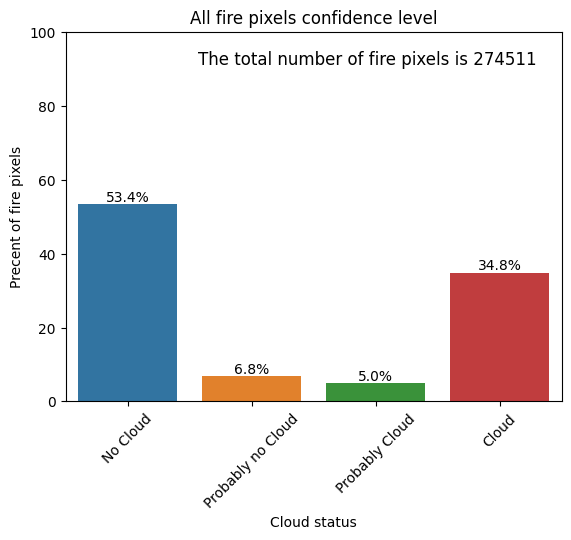

In [131]:
ax = sns.barplot(x="Cloud_pixel_name", y="Precent", data=df_all_fire_pixels)
plt.xticks(rotation=45) ## rotate the x axis labels
plt.xlabel("Cloud status")
plt.ylabel("Precent of fire pixels")
plt.title("All fire pixels confidence level")
ax.set_ylim(0,100) ## set the y axis limit
# Add text to the top-right corner
plt.text(
    x=0.95, y=0.95,  # Position in relative figure coordinates (0 to 1 scale)
    s=f"The total number of fire pixels is {len(fire_pixel_df)}",  # The text to display
    fontsize=12,  # Font size
    ha='right', va='top',  # Align text to the top-right
    transform=plt.gca().transAxes  # Use axes coordinates for positioning
)
# Annotate bars
for p in ax.patches:
    height = p.get_height()  # Get the bar height
    ax.annotate(f'{height:.1f}%',  # Text to display
                (p.get_x() + p.get_width() / 2., height),  # Position at bar center
                ha='center', va='bottom')  # Align center and bottom

* Now we can see the precent of fires that have clouds in them divided into fire confidence levels

In [78]:
fire_pixels_list = [[10,30],[11,31], [12,32], [13,33], [14,34], [15,35]] ## list of fire pixels
fire_confidence_list = ["processed", "saturated", "cloud contaminated", "high", "medium", "low"] ## list of fire confidence

In [84]:
list_of_confidence_df = [] ## list to store the dataframes
for i in range(len(fire_pixels_list)): ## loop over all the fire pixels
    filter_df = fire_pixel_df[np.isin(fire_pixel_df["Fire_pixel_value"], fire_pixels_list[i])] ## filter the dataframe
    list_of_confidence_df.append(filter_df) ## append the filtered dataframe to the list

In [91]:
list_of_confidence_df[5]

,File_name,File_time,Fire_pixel_value,Cloud_pixel_value
2,s202201010731.nc,2022-01-01 07:31,35,0
1,s202201011846.nc,2022-01-01 18:46,15,3
11,s202201011846.nc,2022-01-01 18:46,35,0
3,s202201012021.nc,2022-01-01 20:21,15,0
5,s202201012021.nc,2022-01-01 20:21,35,0
...,...,...,...,...
5,s202312312101.nc,2023-12-31 21:01,15,0
14,s202312312101.nc,2023-12-31 21:01,35,1
18,s202312312101.nc,2023-12-31 21:01,35,0
19,s202312312101.nc,2023-12-31 21:01,15,0


In [112]:
def get_summarize_df(fire_pixel_df):
    """This function gets a df with fire pixels and returns a summarized dataframe

    Args:
        fire_pixel_df (DataFrame): a dataframe with fire pixels
    """
    value_list = [] ## list to store the values
    precent_list = [] ## list to store the precent
    name_list = [] ## list to store the names
    number_list = [] ## list to store the numbers
    for i in dict(fire_pixel_df["Cloud_pixel_value"].value_counts()):
        if np.isin(i, [0,1,2,3]): ## if i is a legit value
            value_in_precent = round(dict(fire_pixel_df["Cloud_pixel_value"].value_counts())[i]/len(fire_pixel_df)*100,2)
            value_list.append(dict(fire_pixel_df["Cloud_pixel_value"].value_counts())[i])
            precent_list.append(value_in_precent)
            if i == 0:
                name_list.append("No Cloud")
                number_list.append(i)
            elif i == 1:
                name_list.append("Probably no Cloud")
                number_list.append(i)
            elif i == 2:
                name_list.append("Probably Cloud")
                number_list.append(i)
            elif i == 3:
                name_list.append("Cloud")
                number_list.append(i)
            else:
                name_list.append("Unknown error") 
                number_list.append(i)
    df_all_fire_pixels = pd.DataFrame({"Cloud_pixel_value": number_list, "Cloud_pixel_name": name_list, "Total_numbers": value_list, "Precent": precent_list})
    df_all_fire_pixels = df_all_fire_pixels.sort_values(by="Cloud_pixel_value")
    return df_all_fire_pixels

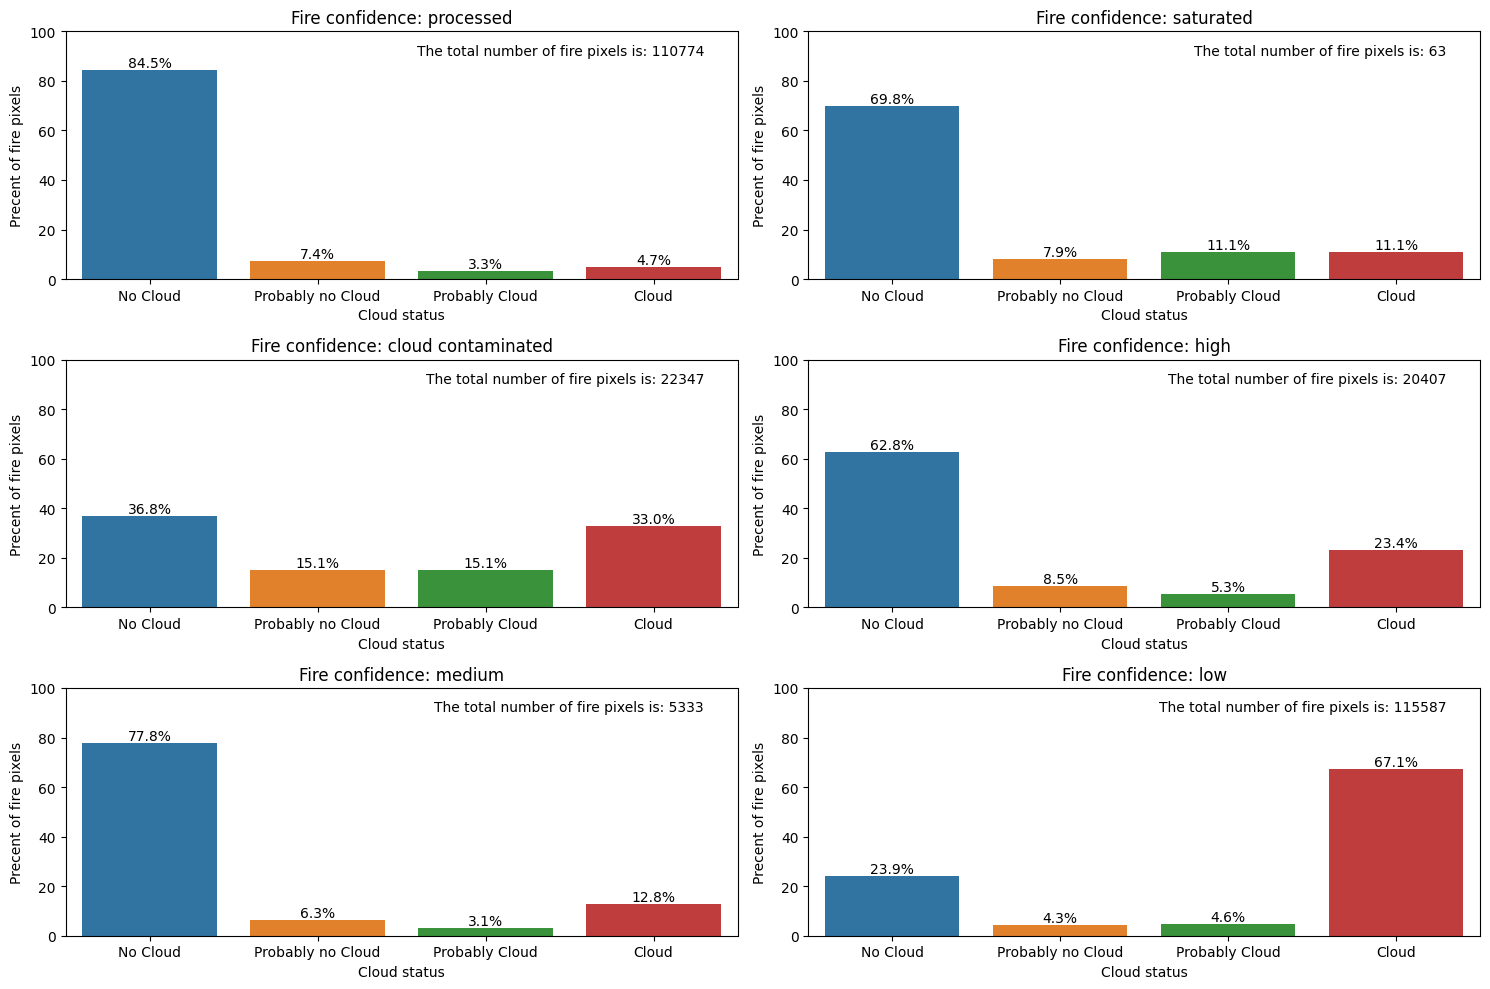

In [130]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10)) ## create a figure
axes = axes.flatten() ## flatten the axes
for i in range(len(list_of_confidence_df)): ## loop over all the dataframes
    summarize_df = get_summarize_df(list_of_confidence_df[i]) ## get the summarized dataframe
    ax = sns.barplot(x="Cloud_pixel_name", y="Precent", data=summarize_df, ax=axes[i]) ## create a barplot
    ax.set_title(f"Fire confidence: {fire_confidence_list[i]}") ## set the title
    ax.set_ylim(0,100) ## set the y axis limit
    ax.set_ylabel("Precent of fire pixels")
    ax.set_xlabel("Cloud status")
    #plt.xticks(rotation=45) ## rotate the x axis labels
    # Add text to the top-right corner
    axes[i].text(
        x=0.95, y=0.95,  # Position in relative figure coordinates (0 to 1 scale)
        s=f"The total number of fire pixels is: {len(list_of_confidence_df[i])}",  # The text to display
        fontsize=10,  # Font size
        ha='right', va='top',  # Align text to the top-right
        transform=axes[i].transAxes  # Use axes coordinates for positioning
    )

# Annotate bars
    for p in ax.patches:
        height = p.get_height()  # Get the bar height
        ax.annotate(f'{height:.1f}%',  # Text to display
                (p.get_x() + p.get_width() / 2., height),  # Position at bar center
                ha='center', va='bottom')  # Align center and bottom
    #plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45) ## rotate the x axis labels
plt.tight_layout() ## tight layout
plt.show()
    